## beat-based manual segmentation


In [35]:
import os
import pretty_midi
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import midi_utils as mu

plt.style.use("dark_background")

### quantization based on beat


In [162]:
def calculate_beat_times(bpm, total_length_seconds, force_120=False):
  """
  Calculate the timing of each beat in a MIDI file based on its total length.

  Args:
  bpm (float): Beats per minute of the MIDI file.
  total_length_seconds (float): Total length of the MIDI clip in seconds.

  Returns:
  list: A list containing the time of each beat in seconds.
  """
  if force_120:
    bpm = 120
  beat_duration = 60.0 / bpm
  total_beats = int(bpm * total_length_seconds / 60)
  return [beat_duration * beat for beat in range(total_beats + 1)]


In [133]:
def scale_midi_tempo(midi_obj, original_tempo, target_tempo):
    """
    Scales the tempo of a MIDI file.

    Args:
    midi_obj (pretty_midi.PrettyMIDI): The PrettyMIDI object to be modified.
    original_tempo (float): The original tempo of the MIDI file in beats per minute.
    target_tempo (float): The target tempo in beats per minute.

    Returns:
    pretty_midi.PrettyMIDI: The modified PrettyMIDI object with scaled tempo.
    """
    # Calculate the ratio of the target tempo to the original tempo
    tempo_ratio = target_tempo / original_tempo
    print(f"scaling tempo by {tempo_ratio}")

    # Scale the start and end times of each note in each instrument
    for instrument in midi_obj.instruments:
        for note in instrument.notes:
            note.start *= tempo_ratio
            note.end *= tempo_ratio

    # Scale tempo change events, if any
    print(f"OG tempo is {midi_obj.get_tempo_changes()}")
    # for tempo_change in midi_obj.get_tempo_changes()[1]:
    #     midi_obj.adjust_times([tempo_change], [tempo_change * tempo_ratio])

    # Return the modified PrettyMIDI object
    return midi_obj


In [165]:
def split_midi(midi_file_path, actual_tempo, beats_per_segment, output_folder):
    """
    Splits a MIDI file into segments based on the given beat timings and number of beats per segment.

    :param midi_file_path: Path to the MIDI file.
    :param actual_tempo: The actual tempo (BPM) of the MIDI file.
    :param beat_timings: List of beat timings at the given tempo.
    :param beats_per_segment: Number of beats in each segment.
    :param output_folder: Folder to save the split MIDI files.
    """
    filename = Path(midi_file_path).stem

    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    # Adjust for the actual tempo
    default_tempo = 120
    tempo_scaling_factor = actual_tempo / default_tempo

    # Scale beat timings
    scaled_beat_timings = calculate_beat_times(120, midi_data.get_end_time())
    # scaled_beat_timings = np.array(beat_timings) * tempo_scaling_factor
    
    # Calculate segment start and end times
    segment_times = [(scaled_beat_timings[i], scaled_beat_timings[min(i + beats_per_segment, len(scaled_beat_timings) - 1)])
                     for i in range(0, len(scaled_beat_timings), beats_per_segment)]

    for i, (start_time, end_time) in enumerate(segment_times):
        # Create a new MIDI object for each segment
        segment_midi = pretty_midi.PrettyMIDI()
        output_filename = f'{filename}_{round(start_time)}-{round(end_time)}.mid'

        # Adjust notes for each instrument
        for instrument in midi_data.instruments:
            segment_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=output_filename)
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    print(f"n {start_time} {end_time}\t s {round(note.start, 2)} --> {round(note.start - start_time, 2)}  e {round(note.end, 2)} --> {round(min(note.end, end_time) - start_time, 2)}")
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=note.start - start_time,
                        end=min(note.end, end_time) - start_time
                    )
                    segment_instrument.notes.append(new_note)
            segment_midi.instruments.append(segment_instrument)

        # Save the segment
        segment_file_path = os.path.join(output_folder, output_filename)
        segment_midi.write(segment_file_path)
        print(f"Segment {i+1} saved to {segment_file_path}")

midi_file = os.path.join("data", "trimmed outputs", "20231220-80-2-t.mid")
midi = pretty_midi.PrettyMIDI(midi_file)
dir_out = os.path.join("data", "beats-trouble")
fs = 100
segs = 8
split_midi(midi_file, 64, segs, dir_out)


n 0.0 4.0	 s 0.0 --> 0.0  e 0.56 --> 0.56
n 0.0 4.0	 s 0.54 --> 0.54  e 0.72 --> 0.72
n 0.0 4.0	 s 0.56 --> 0.56  e 0.73 --> 0.73
n 0.0 4.0	 s 0.54 --> 0.54  e 0.76 --> 0.76
n 0.0 4.0	 s 0.78 --> 0.78  e 1.06 --> 1.06
n 0.0 4.0	 s 1.03 --> 1.03  e 1.1 --> 1.1
n 0.0 4.0	 s 1.05 --> 1.05  e 1.1 --> 1.1
n 0.0 4.0	 s 1.06 --> 1.06  e 1.1 --> 1.1
n 0.0 4.0	 s 1.05 --> 1.05  e 1.1 --> 1.1
n 0.0 4.0	 s 1.27 --> 1.27  e 1.36 --> 1.36
n 0.0 4.0	 s 1.27 --> 1.27  e 1.36 --> 1.36
n 0.0 4.0	 s 1.26 --> 1.26  e 1.38 --> 1.38
n 0.0 4.0	 s 1.28 --> 1.28  e 1.39 --> 1.39
n 0.0 4.0	 s 1.77 --> 1.77  e 2.17 --> 2.17
n 0.0 4.0	 s 2.26 --> 2.26  e 2.51 --> 2.51
n 0.0 4.0	 s 2.53 --> 2.53  e 2.63 --> 2.63
n 0.0 4.0	 s 2.52 --> 2.52  e 2.65 --> 2.65
n 0.0 4.0	 s 2.53 --> 2.53  e 2.66 --> 2.66
n 0.0 4.0	 s 2.74 --> 2.74  e 2.85 --> 2.85
n 0.0 4.0	 s 3.01 --> 3.01  e 3.48 --> 3.48
n 0.0 4.0	 s 3.01 --> 3.01  e 3.49 --> 3.49
n 0.0 4.0	 s 3.0 --> 3.0  e 3.49 --> 3.49
n 0.0 4.0	 s 2.99 --> 2.99  e 3.52 --> 3.52


### beat visualization test


scaling tempo by 0.6666666666666666
OG tempo is (array([0.]), array([120.]))
loaded file 8-80-short at bpm (array([0.]), array([120.]))
[00] segment 0 start 0.0 end 4.0. beats are [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
[0]	adding note (31, 0.0 -> 0.0, 0.37 -> 0.37) to segment 0 (0.0, 4.0)
[1]	adding note (53, 0.36 -> 0.36, 0.48 -> 0.48) to segment 0 (0.0, 4.0)
[2]	adding note (58, 0.37 -> 0.37, 0.49 -> 0.49) to segment 0 (0.0, 4.0)
[3]	adding note (62, 0.36 -> 0.36, 0.5 -> 0.5) to segment 0 (0.0, 4.0)
[4]	adding note (31, 0.52 -> 0.52, 0.71 -> 0.71) to segment 0 (0.0, 4.0)
[5]	adding note (36, 0.69 -> 0.69, 0.73 -> 0.73) to segment 0 (0.0, 4.0)
[6]	adding note (60, 0.7 -> 0.7, 0.73 -> 0.73) to segment 0 (0.0, 4.0)
[7]	adding note (64, 0.7 -> 0.7, 0.73 -> 0.73) to segment 0 (0.0, 4.0)
[8]	adding note (55, 0.7 -> 0.7, 0.74 -> 0.74) to segment 0 (0.0, 4.0)
[9]	adding note (60, 0.85 -> 0.85, 0.91 -> 0.91) to segment 0 (0.0, 4.0)
[10]	adding note (64, 0.85 -> 0.85, 0.91 -> 0.91) to s

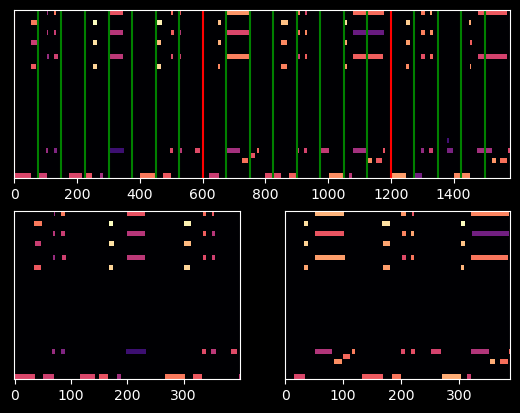

In [144]:
# midi_folder = os.path.join("data", "time", "20231220-80-1-t", "20231220-80-1-t_0-8.mid")
midi_file = os.path.join("data", "8-80-short.mid")
dir_out = os.path.join("data", "beats-trouble")
fs = 100
segs = 8
bpm = 80

midi = pretty_midi.PrettyMIDI(midi_file)
piano_roll = midi.get_piano_roll(fs)
beats = calculate_beat_times(bpm, midi.get_end_time(), True)
segments = split_midi_into_beats(midi_file, dir_out, segs)

# plot
plt.subplot(2, 1, 1)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(piano_roll), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
for i, beat in enumerate(beats):
    plt.axvline(x=beat * fs, color='r' if i % segs == 0 else 'g')

plt.subplot(2, 2, 3)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(segments[0].get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
    
plt.subplot(2, 2, 4)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(segments[1].get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.show()

In [39]:
from midi_player import MIDIPlayer
from midi_player.stylers import dark

segments[0].write('tmp.mid')
MIDIPlayer('tmp.mid', 400, styler=dark)

## Visualizing Quantization Effects


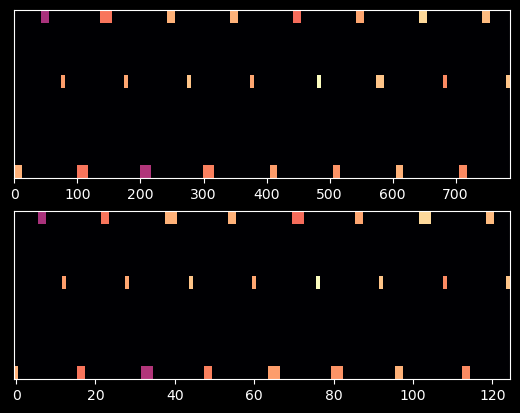

In [40]:
midi_folder = os.path.join("data", "time", "20231220-80-1-t", "20231220-80-1-t_0-8.mid")
dir_out = os.path.join("data", "beats")
tempo = 80
subds = 12

fpr= pretty_midi.PrettyMIDI(midi_folder)
qpr = mu.quantize_midi(midi_folder, subds)

qpr.write(os.path.join("data", "beats-quantized", "20231220-80-1-tq_0-8.mid"))

plt.subplot(2, 1, 1)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(qpr.get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.subplot(2, 1, 2)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(fpr.get_piano_roll(fs=round(1/(60/(tempo * subds))))), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.show()

### Actually segment, then generate


In [41]:
bs_path = os.path.join("data", "beats")
all_in_path = os.path.join("data", "trimmed outputs")
segments = []

for file in os.listdir(all_in_path):
  segments.append(split_midi_into_beats(os.path.join(all_in_path, file), bs_path, 8))

segments_flat = [segment for segmentss in segments for segment in segmentss]
target_len = round(segments_flat[0].get_piano_roll().shape[1]/100)*100
for segment in segments_flat:
  seg_shape = segment.get_piano_roll().shape
  if seg_shape[1] != target_len:
    print(f"{segment.instruments[0].name} has bad length {seg_shape} (wanted {target_len})")
print(f"generated {len(segments_flat)} segments")

[0.0, 0.9090909090909091, 1.8181818181818181, 2.727272727272727, 3.6363636363636362, 4.545454545454545, 5.454545454545454, 6.363636363636363, 7.2727272727272725, 8.181818181818182, 9.09090909090909, 10.0, 10.909090909090908, 11.818181818181818, 12.727272727272727, 13.636363636363637, 14.545454545454545, 15.454545454545453, 16.363636363636363, 17.272727272727273, 18.18181818181818, 19.09090909090909, 20.0, 20.90909090909091, 21.818181818181817, 22.727272727272727, 23.636363636363637, 24.545454545454543, 25.454545454545453, 26.363636363636363, 27.272727272727273, 28.18181818181818, 29.09090909090909, 30.0, 30.909090909090907, 31.818181818181817, 32.72727272727273, 33.63636363636363, 34.54545454545455]
segment 0 start 0.0 end 7.2727272727272725
segment 8 start 7.2727272727272725 end 14.545454545454545
segment 16 start 14.545454545454545 end 21.818181818181817
segment 24 start 21.818181818181817 end 29.09090909090909
segment 32 start 29.09090909090909 end 35.84375
split 20240121-66-2-t int